In [1]:
import pandas as pd

In [2]:
# Load cleaned charging data
charging_data: pd.DataFrame = pd.read_pickle('data/charging_modified.pkl')

# Drop columns with user_* prefix
charging_data = charging_data.drop(columns=charging_data.filter(regex='^user_', axis=1).columns)

# Trim dataset to start when siteID 1 was introduced
introduction_date_site_1 = charging_data[charging_data['siteID'] == 1]['connectionTime'].min()
display(introduction_date_site_1)
charging_data = charging_data[charging_data['connectionTime'] >= introduction_date_site_1]

# Concat with weather dataset
weather_df = pd.read_pickle('data/weather_modified.pkl')

charging_data_copy = charging_data.copy()

# Trim to connectionTime to full hours 
charging_data_copy['connectionTime'] = charging_data_copy['connectionTime'].dt.floor('H')
weather_df['timestamp'] = weather_df['timestamp'].dt.floor('H')

# Merge with connectionTime in charging_data and timestamp in weather_df
charging_data_copy = charging_data_copy.merge(weather_df, left_on='connectionTime', right_on='timestamp', how='left')

# Add columns to charging_data
charging_data['temperature'] = charging_data_copy['temperature']
charging_data['precipitation'] = charging_data_copy['precipitation']
charging_data['windspeed'] = charging_data_copy['windspeed']
charging_data['cloud_cover_description'] = charging_data_copy['cloud_cover_description']

# Encode cloud_cover_description as one hot
charging_data = pd.get_dummies(charging_data, columns=['cloud_cover_description'])
charging_data = pd.get_dummies(charging_data, columns=['weekday'])

# Print head
display(charging_data.head())

# Print row count
charging_data = charging_data.dropna()
print(f'Row count: {charging_data.shape[0]}')

Timestamp('2018-09-05 11:04:13+0000', tz='UTC')

,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,siteID,spaceID,stationID,userID,fullyCharged,NoChargingTime,...,cloud_cover_description_Smoke,cloud_cover_description_T-Storm,cloud_cover_description_Thunder in the Vicinity,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
8582,2018-09-05 11:04:13+00:00,2018-09-05 19:09:35+00:00,NaT,9.583,1,AG-3F32,1-1-179-800,NaN,False,0 days 00:00:00,...,False,False,False,False,False,False,False,False,False,True
8583,2018-09-05 11:08:09+00:00,2018-09-05 14:09:02+00:00,NaT,7.114,1,AG-3F20,1-1-179-794,333.0,False,0 days 00:00:00,...,False,False,False,False,False,False,False,False,False,True
8584,2018-09-05 11:54:27+00:00,2018-09-05 20:02:46+00:00,2018-09-05 16:08:09+00:00,12.188,2,CA-494,2-39-78-367,NaN,True,0 days 04:13:42,...,False,False,False,False,False,False,False,False,False,True
8585,2018-09-05 12:35:14+00:00,2018-09-06 00:30:12+00:00,NaT,11.774,1,AG-3F23,1-1-179-797,371.0,False,0 days 00:00:00,...,False,False,False,False,False,False,False,False,False,True
8586,2018-09-05 12:51:31+00:00,2018-09-05 22:32:58+00:00,NaT,6.280,1,AG-3F31,1-1-179-781,405.0,False,0 days 00:00:00,...,False,False,False,False,False,False,False,False,False,True


Row count: 37991


# Preparing the data

## Basic data cleaning of null values

In [3]:
# Display null values
display(charging_data.isnull().sum())

# Drop columns with null values
# Dropping doneChargingTime is not an issue as this information is already encoded into ChargingTime and NoChargingTime
charging_data = charging_data.drop(columns=['userID', 'doneChargingTime'])
display(display(charging_data.isnull().sum()))

connectionTime                                     0
disconnectTime                                     0
doneChargingTime                                   0
kWhDelivered                                       0
siteID                                             0
spaceID                                            0
stationID                                          0
userID                                             0
fullyCharged                                       0
NoChargingTime                                     0
NoChargingTimeMinutes                              0
NoChargingTimeHours                                0
ChargingTime                                       0
ChargingTimeMinutes                                0
ChargingTimeHours                                  0
kWhPerMinute                                       0
month                                              0
userRegistered                                     0
temperature                                   

connectionTime                                     0
disconnectTime                                     0
kWhDelivered                                       0
siteID                                             0
spaceID                                            0
stationID                                          0
fullyCharged                                       0
NoChargingTime                                     0
NoChargingTimeMinutes                              0
NoChargingTimeHours                                0
ChargingTime                                       0
ChargingTimeMinutes                                0
ChargingTimeHours                                  0
kWhPerMinute                                       0
month                                              0
userRegistered                                     0
temperature                                        0
precipitation                                      0
windspeed                                     

None

## Convert columns to better fit clustering

In [4]:
display(charging_data.head())

,connectionTime,disconnectTime,kWhDelivered,siteID,spaceID,stationID,fullyCharged,NoChargingTime,NoChargingTimeMinutes,NoChargingTimeHours,...,cloud_cover_description_Smoke,cloud_cover_description_T-Storm,cloud_cover_description_Thunder in the Vicinity,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
8676,2018-09-06 01:03:55+00:00,2018-09-06 03:14:01+00:00,14.897,2,CA-319,2-39-95-27,True,0 days 02:10:02,130.033333,2.167222,...,False,False,False,False,False,False,False,True,False,False
8688,2018-09-06 02:56:37+00:00,2018-09-06 13:19:46+00:00,27.422,2,CA-313,2-39-123-23,True,0 days 04:09:50,249.833333,4.163889,...,False,False,False,False,False,False,False,True,False,False
8693,2018-09-06 03:27:40+00:00,2018-09-06 16:12:09+00:00,44.881,2,CA-325,2-39-79-377,True,0 days 12:31:32,751.533333,12.525556,...,False,False,False,False,False,False,False,True,False,False
8796,2018-09-06 22:28:32+00:00,2018-09-07 01:47:18+00:00,21.269,2,CA-317,2-39-91-437,True,0 days 03:18:41,198.683333,3.311389,...,False,False,False,False,False,False,False,True,False,False
8818,2018-09-07 01:26:22+00:00,2018-09-07 02:25:58+00:00,6.414,2,CA-303,2-39-139-28,True,0 days 00:59:32,59.533333,0.992222,...,False,False,False,True,False,False,False,False,False,False


### Expand date columns and add additional columns

In [5]:
# Split connectionTime and disconnectTime into date and time
def split_datetime_to_date_and_time(data: pd.DataFrame, col: str):
    data[col] = pd.to_datetime(data[col])
    data[col + 'Day'] = data[col].dt.day
    data[col + 'Month'] = data[col].dt.month
    data[col + 'Year'] = data[col].dt.year
    data[col + 'Hour'] = data[col].dt.hour
    data[col + 'Minute'] = data[col].dt.minute
    return data

charging_data = split_datetime_to_date_and_time(charging_data, 'connectionTime')
charging_data = split_datetime_to_date_and_time(charging_data, 'disconnectTime')

charging_data['ConnectionDurationInMinutes'] = (charging_data['disconnectTime'] - charging_data['connectionTime']).dt.total_seconds() / 60
charging_data['ConnectionDurationInHours'] = charging_data['ConnectionDurationInMinutes'] / 60

# Drop the original columns
full_charging_data = charging_data.copy()
display(charging_data.head())

,connectionTime,disconnectTime,kWhDelivered,siteID,spaceID,stationID,fullyCharged,NoChargingTime,NoChargingTimeMinutes,NoChargingTimeHours,...,connectionTimeYear,connectionTimeHour,connectionTimeMinute,disconnectTimeDay,disconnectTimeMonth,disconnectTimeYear,disconnectTimeHour,disconnectTimeMinute,ConnectionDurationInMinutes,ConnectionDurationInHours
8676,2018-09-06 01:03:55+00:00,2018-09-06 03:14:01+00:00,14.897,2,CA-319,2-39-95-27,True,0 days 02:10:02,130.033333,2.167222,...,2018,1,3,6,9,2018,3,14,130.100000,2.168333
8688,2018-09-06 02:56:37+00:00,2018-09-06 13:19:46+00:00,27.422,2,CA-313,2-39-123-23,True,0 days 04:09:50,249.833333,4.163889,...,2018,2,56,6,9,2018,13,19,623.150000,10.385833
8693,2018-09-06 03:27:40+00:00,2018-09-06 16:12:09+00:00,44.881,2,CA-325,2-39-79-377,True,0 days 12:31:32,751.533333,12.525556,...,2018,3,27,6,9,2018,16,12,764.483333,12.741389
8796,2018-09-06 22:28:32+00:00,2018-09-07 01:47:18+00:00,21.269,2,CA-317,2-39-91-437,True,0 days 03:18:41,198.683333,3.311389,...,2018,22,28,7,9,2018,1,47,198.766667,3.312778
8818,2018-09-07 01:26:22+00:00,2018-09-07 02:25:58+00:00,6.414,2,CA-303,2-39-139-28,True,0 days 00:59:32,59.533333,0.992222,...,2018,1,26,7,9,2018,2,25,59.600000,0.993333


In [6]:
# spaceID and stationID are irrelevant for clustering, as users can just use another spot if one is occupied
charging_data = charging_data.drop(columns=['spaceID', 'stationID'])
display(charging_data.head())

,connectionTime,disconnectTime,kWhDelivered,siteID,fullyCharged,NoChargingTime,NoChargingTimeMinutes,NoChargingTimeHours,ChargingTime,ChargingTimeMinutes,...,connectionTimeYear,connectionTimeHour,connectionTimeMinute,disconnectTimeDay,disconnectTimeMonth,disconnectTimeYear,disconnectTimeHour,disconnectTimeMinute,ConnectionDurationInMinutes,ConnectionDurationInHours
8676,2018-09-06 01:03:55+00:00,2018-09-06 03:14:01+00:00,14.897,2,True,0 days 02:10:02,130.033333,2.167222,0 days 02:10:02,130.033333,...,2018,1,3,6,9,2018,3,14,130.100000,2.168333
8688,2018-09-06 02:56:37+00:00,2018-09-06 13:19:46+00:00,27.422,2,True,0 days 04:09:50,249.833333,4.163889,0 days 04:09:50,249.833333,...,2018,2,56,6,9,2018,13,19,623.150000,10.385833
8693,2018-09-06 03:27:40+00:00,2018-09-06 16:12:09+00:00,44.881,2,True,0 days 12:31:32,751.533333,12.525556,0 days 12:31:32,751.533333,...,2018,3,27,6,9,2018,16,12,764.483333,12.741389
8796,2018-09-06 22:28:32+00:00,2018-09-07 01:47:18+00:00,21.269,2,True,0 days 03:18:41,198.683333,3.311389,0 days 03:18:41,198.683333,...,2018,22,28,7,9,2018,1,47,198.766667,3.312778
8818,2018-09-07 01:26:22+00:00,2018-09-07 02:25:58+00:00,6.414,2,True,0 days 00:59:32,59.533333,0.992222,0 days 00:59:32,59.533333,...,2018,1,26,7,9,2018,2,25,59.600000,0.993333


### One hot encode nominal columns

In [7]:
# One hot encode nominal columns
# this increases the dimensionality of the data (labels encoding would imply an ordinal relationship between the values)
charging_data = pd.get_dummies(charging_data, columns=['siteID'])
display(charging_data.head())

,connectionTime,disconnectTime,kWhDelivered,fullyCharged,NoChargingTime,NoChargingTimeMinutes,NoChargingTimeHours,ChargingTime,ChargingTimeMinutes,ChargingTimeHours,...,connectionTimeMinute,disconnectTimeDay,disconnectTimeMonth,disconnectTimeYear,disconnectTimeHour,disconnectTimeMinute,ConnectionDurationInMinutes,ConnectionDurationInHours,siteID_1,siteID_2
8676,2018-09-06 01:03:55+00:00,2018-09-06 03:14:01+00:00,14.897,True,0 days 02:10:02,130.033333,2.167222,0 days 02:10:02,130.033333,2.167222,...,3,6,9,2018,3,14,130.100000,2.168333,False,True
8688,2018-09-06 02:56:37+00:00,2018-09-06 13:19:46+00:00,27.422,True,0 days 04:09:50,249.833333,4.163889,0 days 04:09:50,249.833333,4.163889,...,56,6,9,2018,13,19,623.150000,10.385833,False,True
8693,2018-09-06 03:27:40+00:00,2018-09-06 16:12:09+00:00,44.881,True,0 days 12:31:32,751.533333,12.525556,0 days 12:31:32,751.533333,12.525556,...,27,6,9,2018,16,12,764.483333,12.741389,False,True
8796,2018-09-06 22:28:32+00:00,2018-09-07 01:47:18+00:00,21.269,True,0 days 03:18:41,198.683333,3.311389,0 days 03:18:41,198.683333,3.311389,...,28,7,9,2018,1,47,198.766667,3.312778,False,True
8818,2018-09-07 01:26:22+00:00,2018-09-07 02:25:58+00:00,6.414,True,0 days 00:59:32,59.533333,0.992222,0 days 00:59:32,59.533333,0.992222,...,26,7,9,2018,2,25,59.600000,0.993333,False,True


## Cyclic encoding of time

In [8]:
# Taken from https://medium.com/@TheDataSciencePro/revolutionizing-predictive-analytics-unveiling-the-power-of-cyclical-feature-encoding-78c765ffc9bf
def encode_cyclical_feature(data: pd.DataFrame, feature: str, period: int):
    """
    Encode a cyclical feature into two dimensions (sin and cos components).
    
    Parameters:
    - data: DataFrame containing the dataset.
    - feature: Name of the cyclical feature column.
    - period: The period of the cyclical pattern.
    """
    import numpy as np
    from sklearn.preprocessing import StandardScaler
    
    scaled_feature = StandardScaler().fit_transform(data[[feature]])
    
    data[feature + '_sin'] = np.sin(2 * np.pi * scaled_feature / period)
    data[feature + '_cos'] = np.cos(2 * np.pi * scaled_feature / period)

def encode_datetime_to_cyclic(data: pd.DataFrame, feature: str):
    suffixes: list[tuple[str, int]] = [('Month', 12), ('Day', 31), ('Hour', 24), ('Minute', 60)]
    for suffix, period in suffixes:
        # Check if column exists
        column_name = feature + suffix
        if column_name in data.columns:
            encode_cyclical_feature(data, column_name, period)    

# Create a copy
prepared_data = charging_data.copy()

# Encode the time components to cyclic
encode_datetime_to_cyclic(prepared_data, 'connectionTime')
encode_datetime_to_cyclic(prepared_data, 'disconnectTime')

display(prepared_data.head())

,connectionTime,disconnectTime,kWhDelivered,fullyCharged,NoChargingTime,NoChargingTimeMinutes,NoChargingTimeHours,ChargingTime,ChargingTimeMinutes,ChargingTimeHours,...,connectionTimeMinute_sin,connectionTimeMinute_cos,disconnectTimeMonth_sin,disconnectTimeMonth_cos,disconnectTimeDay_sin,disconnectTimeDay_cos,disconnectTimeHour_sin,disconnectTimeHour_cos,disconnectTimeMinute_sin,disconnectTimeMinute_cos
8676,2018-09-06 01:03:55+00:00,2018-09-06 03:14:01+00:00,14.897,True,0 days 02:10:02,130.033333,2.167222,0 days 02:10:02,130.033333,2.167222,...,-0.160636,0.987014,0.357191,0.934031,-0.226014,0.974124,-0.189895,0.981804,-0.090630,0.995885
8688,2018-09-06 02:56:37+00:00,2018-09-06 13:19:46+00:00,27.422,True,0 days 04:09:50,249.833333,4.163889,0 days 04:09:50,249.833333,4.163889,...,0.161587,0.986858,0.357191,0.934031,-0.226014,0.974124,0.071658,0.997429,-0.060262,0.998183
8693,2018-09-06 03:27:40+00:00,2018-09-06 16:12:09+00:00,44.881,True,0 days 12:31:32,751.533333,12.525556,0 days 12:31:32,751.533333,12.525556,...,-0.014784,0.999891,0.357191,0.934031,-0.226014,0.974124,0.149983,0.988689,-0.102755,0.994707
8796,2018-09-06 22:28:32+00:00,2018-09-07 01:47:18+00:00,21.269,True,0 days 03:18:41,198.683333,3.311389,0 days 03:18:41,198.683333,3.311389,...,-0.008678,0.999962,0.357191,0.934031,-0.202923,0.979195,-0.241208,0.970474,0.110032,0.993928
8818,2018-09-07 01:26:22+00:00,2018-09-07 02:25:58+00:00,6.414,True,0 days 00:59:32,59.533333,0.992222,0 days 00:59:32,59.533333,0.992222,...,-0.020889,0.999782,0.357191,0.934031,-0.202923,0.979195,-0.215626,0.976476,-0.023749,0.999718


## Methods for clustering

In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

random_state = 42
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer


def kmean(data, n_clusters):
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    labels = kmeans.fit_predict(data)
    return labels, kmeans

def pca(data):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    return pca_result

def pca_based_kmean(data, n_clusters):
    pca_result = pca(data)
    labels, kmeans = kmean(pca_result, n_clusters)
    return labels, kmeans, pca_result

def plot_kmeans(data: pd.DataFrame, labels):
    u_labels = np.unique(labels)
    for i in u_labels:
        plt.scatter(data[labels == i, 0], data[labels == i, 1], label=f'Cluster {i}')
    plt.legend()
    
    # Ensure path figures exists
    import os
    if not os.path.exists('figures'):
        os.makedirs('figures')
    plt.savefig("figures/kmeans-clusters.png")
    plt.show()
    
def perform_kmeans_and_plot(data: pd.DataFrame, n_clusters: int):
    labels, kmeans, pca_result = pca_based_kmean(data, n_clusters)
    plot_kmeans(pca_result, labels)
    return labels, kmeans, pca_result

def scale_df(data: pd.DataFrame) -> pd.DataFrame:
    # Get cyclic columns, i.e., ending _sin or _cos
    cyclic_columns = [col for col in data.columns if col.endswith('_sin') or col.endswith('_cos')] + ['siteID_1', 'siteID_2', 'userRegistered']
    
    # Select columns to scale (excluding cyclic columns)
    columns_to_scale = data.columns.difference(cyclic_columns)
    
    # Create a MinMaxScaler object
    scaler = MinMaxScaler()
    
    # Scale selected columns
    df_scaled = data.copy()  # Make a copy of the original DataFrame
    df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])
    return df_scaled

def visualize_elbow(data, min_clusters=2, max_clusters=10, scale=True):
    input_data = scale_df(data) if scale else data
    display(input_data.head())
    kelbow_visualizer(KMeans(random_state=random_state, n_init='auto'), input_data, k=(min_clusters, max_clusters))
    
def normalize_and_cluster(data: pd.DataFrame, n_clusters: int) -> np.ndarray:
    input_data = scale_df(data)
    labels, kmeans, pca_result = perform_kmeans_and_plot(input_data, n_clusters)
    return labels

# Clustering

In [10]:
# Display columns
display(prepared_data.columns)

Index(['connectionTime', 'disconnectTime', 'kWhDelivered', 'fullyCharged',
       'NoChargingTime', 'NoChargingTimeMinutes', 'NoChargingTimeHours',
       'ChargingTime', 'ChargingTimeMinutes', 'ChargingTimeHours',
       'kWhPerMinute', 'month', 'userRegistered', 'temperature',
       'precipitation', 'windspeed', 'cloud_cover_description_Blowing Dust',
       'cloud_cover_description_Cloudy',
       'cloud_cover_description_Cloudy / Windy',
       'cloud_cover_description_Fair', 'cloud_cover_description_Fair / Windy',
       'cloud_cover_description_Fog', 'cloud_cover_description_Haze',
       'cloud_cover_description_Heavy Rain',
       'cloud_cover_description_Heavy Rain / Windy',
       'cloud_cover_description_Heavy T-Storm',
       'cloud_cover_description_Light Rain',
       'cloud_cover_description_Light Rain / Windy',
       'cloud_cover_description_Light Rain with Thunder',
       'cloud_cover_description_Mostly Cloudy',
       'cloud_cover_description_Mostly Cloudy / Windy'

## Cluster based all columns

,connectionTimeHour_sin,kWhDelivered,temperature,precipitation
8676,-0.672799,0.191856,0.333333,0.0
8688,-0.632648,0.358800,0.333333,0.0
8693,-0.590718,0.591509,0.333333,0.0
8796,0.366651,0.276788,0.333333,0.0
8818,-0.672799,0.078787,0.333333,0.0


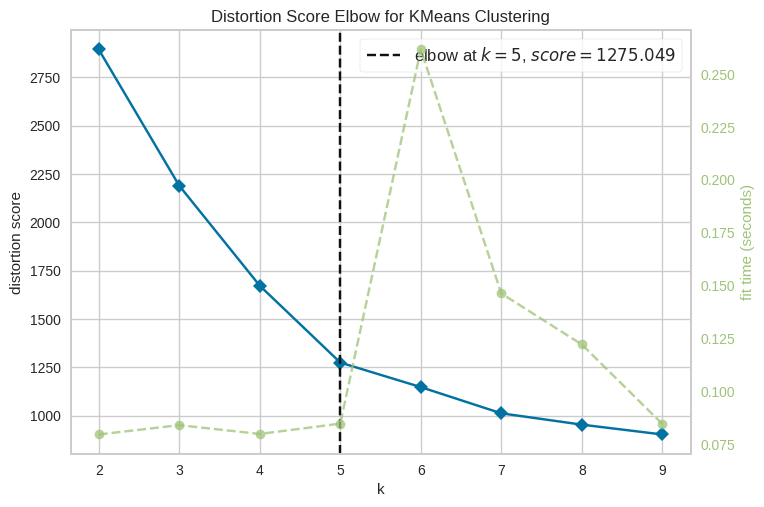

In [11]:
# Get column names containing 'weekday_*' and 'cloud_cover_description_*'

columns_to_show = ['connectionTimeHour_sin', 'kWhDelivered', 'temperature', 'precipitation']
df_all_columns = prepared_data.copy()[columns_to_show]
visualize_elbow(df_all_columns, 2, 10, True)

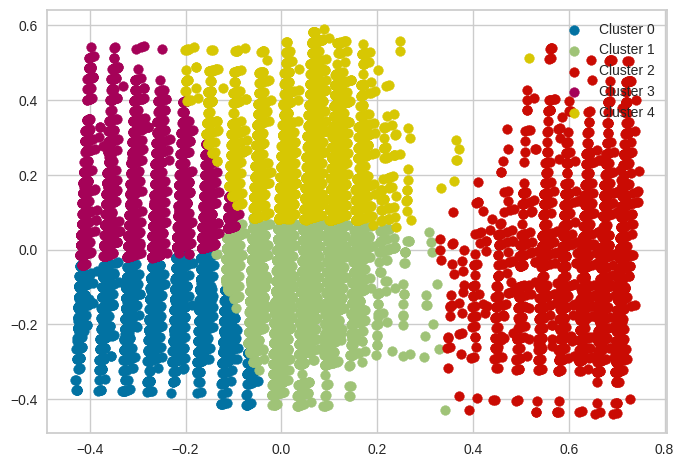

In [12]:
labels = normalize_and_cluster(df_all_columns, 5)

In [ ]:
# Append labels to the original data
full_charging_data_labeled = full_charging_data.copy()
full_charging_data_labeled['cluster'] = labels

# With only ours representation we can't display that the session is going over midnight, so we make disconnectTimeHour equal to connectionTimeHour + ConnectionDurationInHours
full_charging_data_labeled['disconnectTimeHour'] = (full_charging_data_labeled['connectionTimeHour'] + full_charging_data_labeled['ConnectionDurationInHours']).astype(int)

# Restrict to interesting columns
full_charging_data_labeled = full_charging_data_labeled[['connectionTimeHour',  'kWhDelivered', 'temperature', 'precipitation', 'cluster']]

# Group by cluster and describe
desc = full_charging_data_labeled.groupby('cluster').describe()
display(desc)

# Scatter plot all columns
import seaborn as sns
scatter_plot = sns.pairplot(full_charging_data_labeled, hue='cluster', palette=sns.color_palette("hls", 7))
scatter_plot.savefig("figures/scatter-plot.png")

## Cluster with temperature

In [14]:
weather_df = pd.read_pickle('data/weather_modified.pkl')
weather_df.head()

,city,timestamp,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,felt_temperature
3037,Burbank,2018-04-25 11:53:00+00:00,12.0,27.0,Mostly Cloudy,989.11,6.0,0.0,12.0
3038,Burbank,2018-04-25 12:10:00+00:00,12.0,27.0,Mostly Cloudy,989.11,7.0,0.0,12.0
3039,Burbank,2018-04-25 12:53:00+00:00,12.0,28.0,Mostly Cloudy,989.11,9.0,0.0,12.0
3040,Burbank,2018-04-25 13:24:00+00:00,12.0,20.0,Fog,989.44,9.0,0.0,12.0
3041,Burbank,2018-04-25 13:53:00+00:00,12.0,20.0,Fog,989.44,7.0,0.0,12.0
